In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Libraries

Data preparation

In [27]:
categories = pd.read_csv('categories.csv', encoding='windows-1252', index_col=None)
customers = pd.read_csv('customers.csv', encoding='windows-1252', index_col=None)
employees = pd.read_csv('employees.csv', encoding='windows-1252', index_col=None)
order_details = pd.read_csv('order_details.csv', encoding='windows-1252', index_col=None)
orders = pd.read_csv('orders.csv', encoding='windows-1252', index_col=None)
products = pd.read_csv('products.csv', encoding='windows-1252', index_col=None)
shippers = pd.read_csv('shippers.csv', encoding='windows-1252', index_col=None)

# Reading all of the data in

In [20]:
orders.head()

,orderID,customerID,employeeID,orderDate,requiredDate,shippedDate,shipperID,freight
0,10248,VINET,5,2013-07-04,2013-08-01,2013-07-16,3,32.38
1,10249,TOMSP,6,2013-07-05,2013-08-16,2013-07-10,1,11.61
2,10250,HANAR,4,2013-07-08,2013-08-05,2013-07-12,2,65.83
3,10251,VICTE,3,2013-07-08,2013-08-05,2013-07-15,1,41.34
4,10252,SUPRD,4,2013-07-09,2013-08-06,2013-07-11,2,51.30


In [17]:
order_details.head()

,orderID,productID,unitPrice,quantity,discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


Data cleaning

In [35]:
orders['orderDate'] = pd.to_datetime(orders['orderDate'])
orders['requiredDate'] = pd.to_datetime(orders['requiredDate'])
orders['shippedDate'] = pd.to_datetime(orders['shippedDate'])

# Looking through the data, we see three columns with the object dtype instead of datetime.

In [28]:
employees.info()
# When checking each df, we can see that employees.info() has a missing value from its reportsTo column.
# Before inspection, this is likely that the employee is either the boss, or has no one to report to

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employeeID    9 non-null      int64  
 1   employeeName  9 non-null      object 
 2   title         9 non-null      object 
 3   city          9 non-null      object 
 4   country       9 non-null      object 
 5   reportsTo     8 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 564.0+ bytes


In [29]:
orders.info()
# We can also see with .info() that the orders table also has missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   orderID       830 non-null    int64  
 1   customerID    830 non-null    object 
 2   employeeID    830 non-null    int64  
 3   orderDate     830 non-null    object 
 4   requiredDate  830 non-null    object 
 5   shippedDate   809 non-null    object 
 6   shipperID     830 non-null    int64  
 7   freight       830 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 52.0+ KB


In [31]:
orders.isnull().sum()

orderID          0
customerID       0
employeeID       0
orderDate        0
requiredDate     0
shippedDate     21
shipperID        0
freight          0
dtype: int64

We see that we have missing values for shippedDate, we can assume here that the order simply does not have a value because it hasn't been shipped yet.

Now that we have addressed all missing values and we know what the data looks like, we can begin analysis.

Are there any noticeable sales trends over time?

In [51]:
merged_orders = pd.merge(orders, order_details, on='orderID')

merged_orders['total_sales'] = merged_orders['unitPrice'] * merged_orders['quantity'] * (1-merged_orders['discount'])
monthly_sales = merged_orders.groupby(merged_orders['orderDate'].dt.to_period('M').dt.to_timestamp())['total_sales'].sum().reset_index()

monthly_sales

,orderDate,total_sales
0,2013-07-01,27861.8950
1,2013-08-01,25485.2750
2,2013-09-01,26381.4000
3,2013-10-01,37515.7250
4,2013-11-01,45600.0450
5,2013-12-01,45239.6300
6,2014-01-01,61258.0700
7,2014-02-01,38483.6350
8,2014-03-01,38547.2200
9,2014-04-01,53032.9525


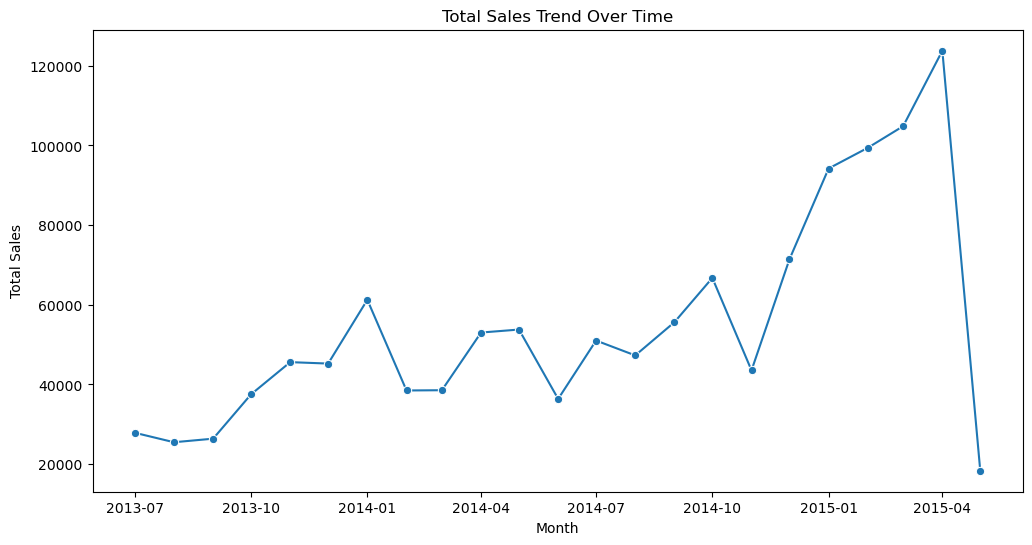

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='orderDate', y='total_sales', data=monthly_sales, marker='o')
plt.title('Total Sales Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

The total sales slowly grew with alternating climbs and falls from July 2013 to October 2014. Starting November of 2014, we can see that there is a large increase in sales, with an estimated 80,000 dollars increase in monthly profit by April 2015. However, by the next month of May, total sales will have tanked and dropped to less than 20,000 dollars.

Which are the best and worst selling products?

In [64]:
merged_products = pd.merge(products, order_details, on='productID')

product_sales = merged_products.groupby(['productID', 'productName'])['quantity'].sum().reset_index()
top_products = product_sales.sort_values(by='quantity', ascending=False).head(5)
worst_products = product_sales.sort_values(by='quantity', ascending=False).tail(5)

combined_products = pd.concat([top_products, worst_products])

In [61]:
top_products

,productID,productName,quantity
59,60,Camembert Pierrot,1577
58,59,Raclette Courdavault,1496
30,31,Gorgonzola Telino,1397
55,56,Gnocchi di nonna Alice,1263
15,16,Pavlova,1158


In [62]:
worst_products

,productID,productName,quantity
66,67,Laughing Lumberjack Lager,184
47,48,Chocolade,138
36,37,Gravad lax,125
14,15,Genen Shouyu,122
8,9,Mishi Kobe Niku,95


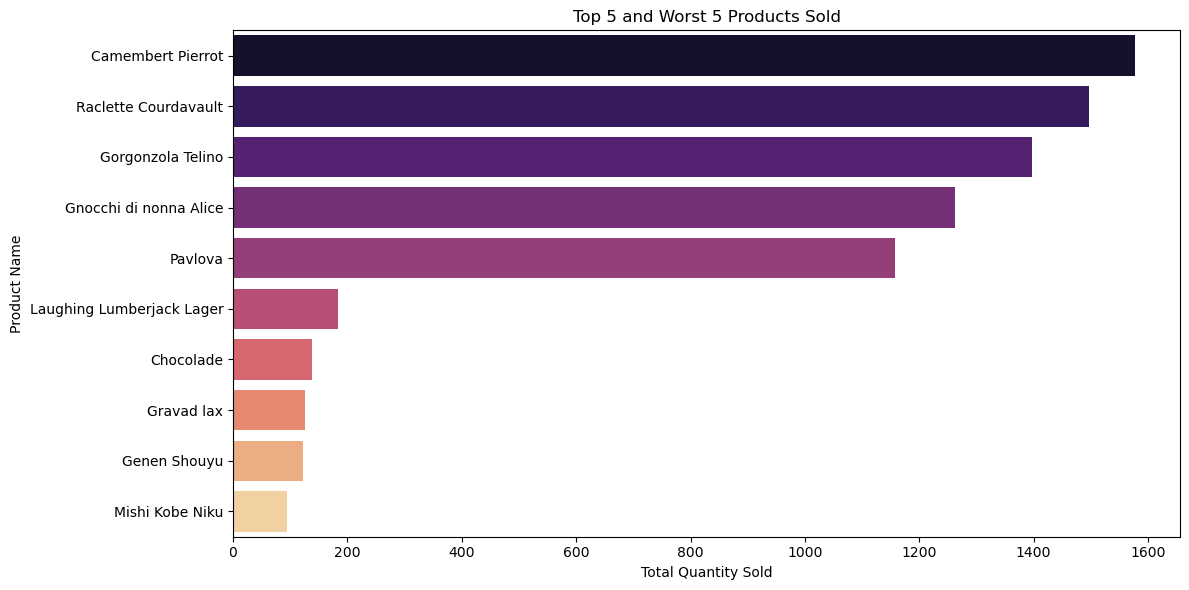

In [69]:
plt.figure(figsize=(12,6))
sns.barplot(x='quantity', y='productName', data=combined_products, palette='magma')
plt.title('Top 5 and Worst 5 Products Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

Can you identify any key customers?

In [72]:
merged_customers = pd.merge(customers, orders, on='customerID')
merged_customers = pd.merge(merged_customers, order_details, on='orderID')

merged_customers['total_spent'] = merged_customers['unitPrice'] * merged_customers['quantity'] * (1 - merged_customers['discount'])
customer_spending = merged_customers.groupby(['customerID', 'companyName'])['total_spent'].sum().reset_index()

top_customers = customer_spending.sort_values(by='total_spent', ascending=False).head(5)
top_customers

,customerID,companyName,total_spent
60,QUICK,QUICK-Stop,110277.3050
19,ERNSH,Ernst Handel,104874.9785
68,SAVEA,Save-a-lot Markets,104361.9500
62,RATTC,Rattlesnake Canyon Grocery,51097.8005
35,HUNGO,Hungry Owl All-Night Grocers,49979.9050


Are shipping costs consistent across providers?

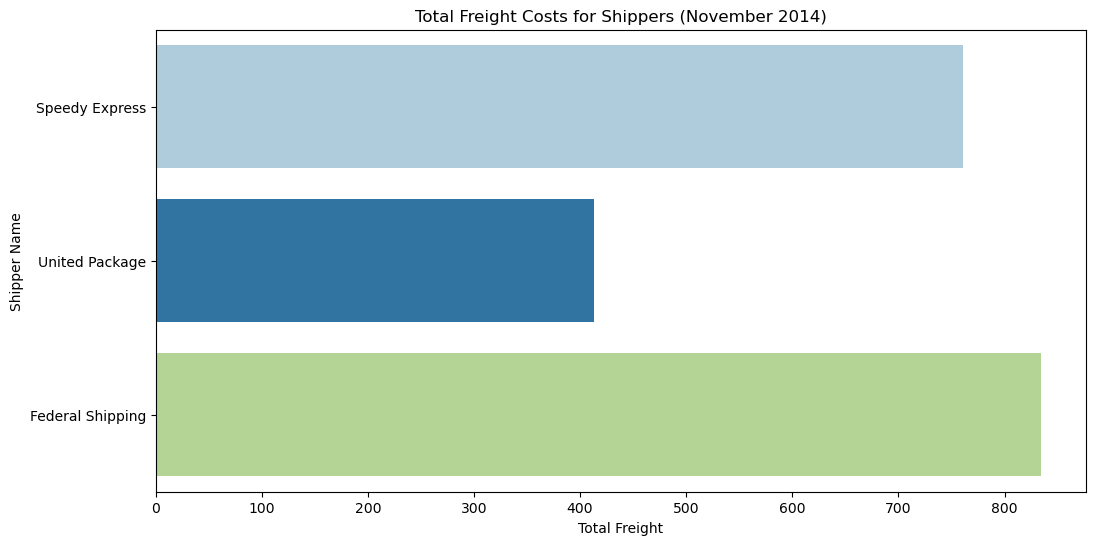

In [76]:
merged_shippers = pd.merge(orders, shippers, on='shipperID')

merged_shippers['month'] = merged_shippers['orderDate'].dt.to_period('M').dt.to_timestamp()
shipper_freight = merged_shippers.groupby(['month', 'shipperID', 'companyName'])['freight'].sum().reset_index()

november_freight = shipper_freight[shipper_freight['month'] == '2014-11']

#filtering for a specific month

plt.figure(figsize=(12, 6))
sns.barplot(x='freight', y='companyName', data=november_freight, palette='Paired')
plt.title('Total Freight Costs for Shippers (November 2014)')
plt.xlabel('Total Freight')
plt.ylabel('Shipper Name')
plt.show()
